## Demonstration of Spiking Neuron Dynamics

In this notebook we explore the dynamics of individual spiking photonic neurons under excitiation, and demonstrate the usage of our Neuron class.  We create a variety of neurons, drive them with external stimuli, and visualize the resultant dynamics.  The preamble is below.

In [1]:
"""
Visualization of single neuron dynamics for various models
"""
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from neuron import Neuron

# also define figure paramaters
#default plot parameters
plotparams = {'figure.figsize': (10, 10),
    'axes.labelsize': '20',
    'axes.titlesize':'22',
    'xtick.labelsize':'20',
    'ytick.labelsize':'20',
    'lines.linewidth' : 3,
    'legend.fontsize': '18',
    'text.usetex': 'True',
    'xtick.major.size': 6.,
    'ytick.major.size': 6.,
    'axes.prop_cycle'    : plt.cycler(color='bgrcmyk')
    }
plt.rcParams.update(plotparams)
#normalized guassian for constructing input signals
Gaussian_pulse= lambda x, mu, sig: np.exp(-np.power(x - mu, 2.) 
    / (2 * np.power(sig, 2.)))/(np.sqrt(2*np.pi)*sig)

Section 1: Yamada laser neuron dynamics under excitation

We first study the dynamics of the "Yamada" Laser neuron model, which describes a two section laser containing a gain region and a saturable absorber.  Input optical signals stimulate a photodiode, which controls the current into the gain region.  The equations of motion are:
\begin{equation} \dot{I}=\kappa(1-G-Q)I+\beta \\ \dot{G}=\gamma(A+i_{in}(t)-G-IG) \\ \dot{Q}=\gamma(B-Q-aIQ) \end{equation}
Where $I$ is the dimensionless laser intensity, and $G$ and $Q$ are the inversions of the gain and saturable absorbing media.  $i_{in}$ sufficient to produce $G+Q>1$ results in a sharp laser pulse and the system then refracts.  For excitability, we require $\gamma\ll\kappa$: the field intensity is our fast "state" variable and the inversions are slow "recovery" variables, like the membrane potential and ion permeability respectively in biological neurons.

We begin by choosing our model parameters, contained in the variable ```Y1mpars``` below.  It is important that we initialize our neuron in its steady state, so we use the neuron member function ```steady_state``` to compute the steady state for our specific choice of model parameters.  To be sucessful, this requires an initial guess of the steady state, which is ```y1_steady_est```.  We then update the full set of parameters ```Y1params``` for the Neuron object we will be creating.

In [2]:
#Demo of spiking Yamada Neuron (version1)
#only spikes for inputs with pulse area >threshold

#basic setup stuff
#Create a basic Yamada Neuron 
Y1mpars={"a": 2, "A": 6.5, "B":-6., "gamma1": 1,
         "gamma2": 1, "kappa": 50, "beta": 5e-1 }#these are the model parameters
y1_steady_est=[Y1mpars['beta']/Y1mpars['kappa'],
               Y1mpars['A'],Y1mpars['B'] ] #quick estimate of ss
Y1params={"model" : "Yamada_1", "y0": y1_steady_est,
    "dt": 1e-2, 'mpar': Y1mpars} #neuron parameters
y1_steady=Neuron(Y1params).steady_state(y1_steady_est)

Y1params["y0"]=y1_steady #change model parameters so that starts w this ss
#now just use Y1params to initialize neurons

We now proceed to initialize a Neuron with ```neuron_object=Neuron(neuron_parameters)```.  We then construct an input signal which is a series of Gaussian inputs, the first of which is below threshold and will not cause the neuron to spike, and the last is very noisy but will.  The Neuron dynamics are then computed with ```output=neuron_object.solve(input)``` 

In [3]:
Y1Neuron1=Neuron(Y1params)

#create time signal, set params in terms of gamma1
t1_end=8./Y1mpars["gamma1"]; #atleast this long
N1=int(np.ceil(t1_end/Y1Neuron1.dt)) #this many points
time1=np.linspace(0.,(N1-1)*Y1Neuron1.dt, num=N1 )

#choose gaussian input
x1=np.zeros(N1)
x1+=0.2*Gaussian_pulse(time1, 0.1/Y1mpars["gamma1"], 3.e-2/Y1mpars["gamma1"])
x1+=0.4*Gaussian_pulse(time1, 2./Y1mpars["gamma1"], 3.e-2/Y1mpars["gamma1"])
x1+=0.4*Gaussian_pulse(time1, 6.5/Y1mpars["gamma1"], 5.e-2/Y1mpars["gamma1"])*np.random.normal(1, 1,N1)

#solve
y_out1=Y1Neuron1.solve(x1)

These results are visualized with ```figure=neuron_object.visualize_plot(input, output, time, steady_state)```.  The upper axis contains the input current to the neuron, and the lower is the resultant dynamics.  The light intensity is the left axis in blue and the gain and absorber inversions are in red and green on the right axis.  The steady states are also indicated with dashed lines.  Note that a spike is not seen for the initial Gaussian input pulse, as its area is below threshold.  The second and third pulses have the same area and thus produce nearly identical responses, even though the later is quite noisy.  The refractory period can also be seen as the large time it takes for the inversion variables to recover after each spike.

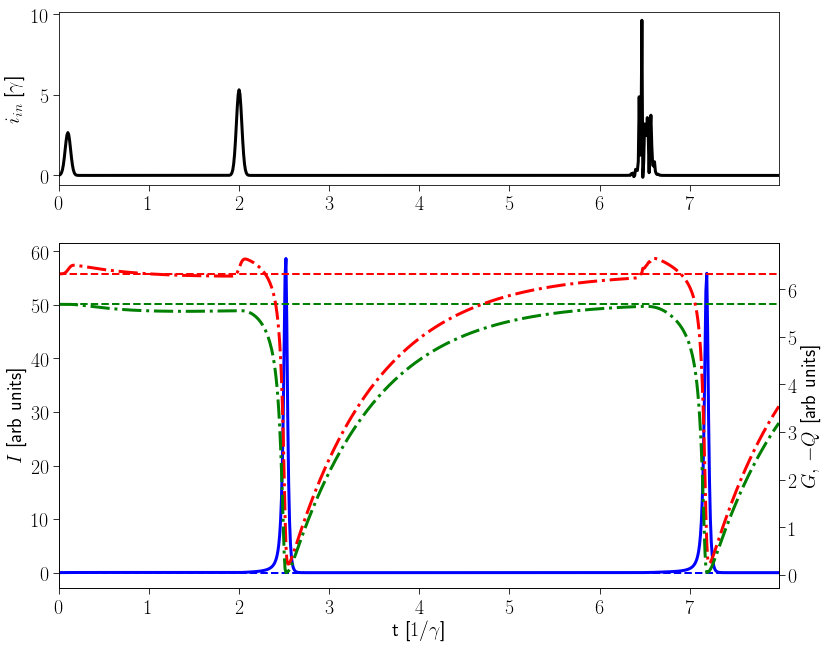

In [4]:
fig1=Y1Neuron1.visualize_plot(x1, y_out1, time1, y1_steady)
fig1.set_size_inches(10, 8, forward=True)
#fig1.savefig('./docs/graphics/noise_neuron_dyn.png', bbox_inches='tight')


We now study neuron dynamics under DC inputs.  If this input is above threshold, the neuron will spike periodically, and this firing rate will increase as the input amplitude is increased.  As before, we initialize a neuron object, solve it for a given input signal, and visualize the result using the member function of Neuron.

In [5]:
# study same neuron as above,
# but now drive with constant signals to see self pusling
Y1Neuron2=Neuron(Y1params)

#create time signal
t2_end=30/Y1mpars["gamma1"]; #atleast this long
N2=int(np.ceil(t2_end/Y1Neuron2.dt))
time2=np.linspace(0.,(N2-1)*Y1Neuron2.dt, num=N2 )

#create steps out of heavisides
x2=np.zeros(N2)
#scale with gamma1 so drive in units of A
x2+=(0.3*Y1mpars["gamma1"])*np.heaviside(time2-2./Y1mpars["gamma1"], 0.5)
x2+=(0.3*Y1mpars["gamma1"])*np.heaviside(time2-8./Y1mpars["gamma1"], 0.5)
x2+=(0.6*Y1mpars["gamma1"])*np.heaviside(time2-16./Y1mpars["gamma1"], 0.5)
x2+=-(1.2*Y1mpars["gamma1"])*np.heaviside(time2-24./Y1mpars["gamma1"], 0.5)

#solve
y_out2=Y1Neuron2.solve(x2)



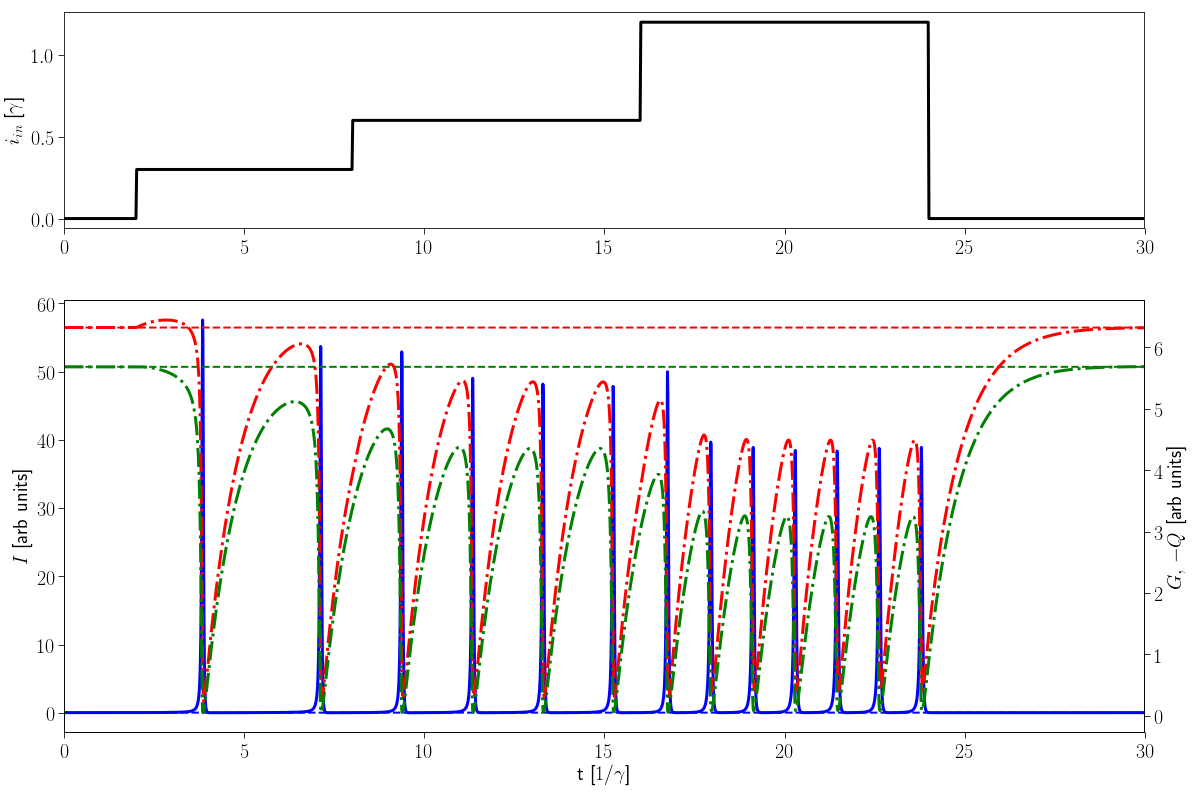

In [6]:
fig2=Y1Neuron2.visualize_plot(x2, y_out2, time2, y1_steady)
fig2.set_size_inches(15, 10, forward=True)
# fig2.savefig('./docs/graphics/dc_neuron_dyn.png', bbox_inches='tight')


Below we generate neuron dynamics as before, this time by driving the neuron with a series of below threshold inputs, showing the neuron's ability to integrate multiple pulses, and also demonstrating that the neuron is more difficult to excite if it is stimulated within the refractory period of a previous spike

In [7]:
# study same neuron as above,
# showing ability to integrate multiple pulses
# also a demonstration of the refractory period

Y1Neuron3=Neuron(Y1params)

#create time signal
t3_end=7/Y1mpars["gamma1"]; #atleast this long
N3=int(np.ceil(t3_end/Y1Neuron3.dt))
time3=np.linspace(0.,(N3-1)*Y1Neuron3.dt, num=N3 )

#create steps out of heavisides
x3=np.zeros(N3)
x3+=0.1*Gaussian_pulse(time3, 0.1/Y1mpars["gamma1"], 1.e-2/Y1mpars["gamma1"])
x3+=0.1*Gaussian_pulse(time3, 0.3/Y1mpars["gamma1"], 1.e-2/Y1mpars["gamma1"])

x3+=0.1*Gaussian_pulse(time3, 2./Y1mpars["gamma1"], 1.e-2/Y1mpars["gamma1"])
x3+=0.1*Gaussian_pulse(time3, 2.2/Y1mpars["gamma1"], 1.e-2/Y1mpars["gamma1"])
x3+=0.1*Gaussian_pulse(time3, 2.4/Y1mpars["gamma1"], 1.e-2/Y1mpars["gamma1"])

x3+=0.1*Gaussian_pulse(time3, 5.4/Y1mpars["gamma1"], 1.e-2/Y1mpars["gamma1"])
x3+=0.1*Gaussian_pulse(time3, 5.6/Y1mpars["gamma1"], 1.e-2/Y1mpars["gamma1"])
x3+=0.1*Gaussian_pulse(time3, 5.8/Y1mpars["gamma1"], 1.e-2/Y1mpars["gamma1"])


#solve
y_out3=Y1Neuron3.solve(x3)


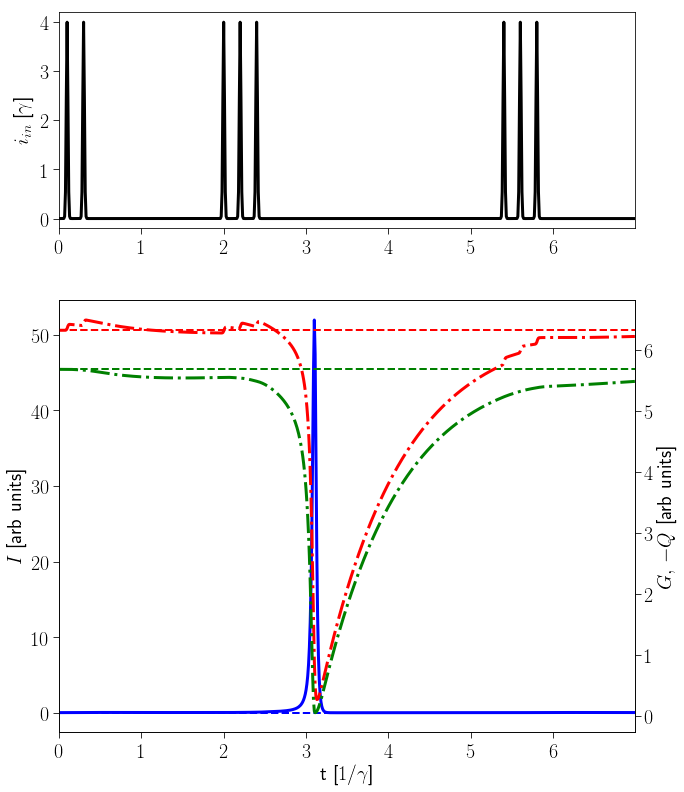

In [8]:
fig3=Y1Neuron3.visualize_plot(x3, y_out3, time3, y1_steady)
fig3.set_size_inches(8, 10, forward=True)
# fig3.savefig('./docs/graphics/multipulse_neuron_dyn.png', bbox_inches='tight')


Section 2: Dynamics of integrated laser neuron (simplified Yamada model)

If $a=1$, the distinction between the gain and absorber media vanish and the Yamada neuron becomes essentially a single mode laser just below threshold driven by a photodiode. This describes early iterations of the integrated laser neuron.  This system lacks true excitability since it doesn't contain a hard threshold and won't repeatedly fire under constant input.  However, it still produces an output which is a nonlinear response of its input and can thus behave as a spiking neuron for the inner layers of a neural network (it is not ideal for the input layer as it wont convert a DC input to a spike train). 

This simplified laser neuron is described by the model ```Yamada_0```.  We define the parameters for one below:

In [9]:

Y0mpars={"P": 0.,"gamma": 8., "kappa": 70., "beta": 2.e-1 }

y0_steady_est=[Y0mpars['beta']/Y0mpars['kappa'], Y0mpars['P'] ]

Y0params={"model" : "Yamada_0", "y0": y0_steady_est,
    "dt": 1.e-3, 'mpar': Y0mpars} #quick estimate of ss
y0_steady=Neuron(Y0params).steady_state(y0_steady_est)
Y0params["y0"]=y0_steady #change model parameters so that starts w this ss
#now just use Y1params to initialize neurons

We initialize an integrated neuron, drive it with a series of Gaussians, and visualize the result below, as done in the previous section.  It can be seen that this simplified neuron still behaves as expected: once the pulse area exceeds a rough threshold, a much stronger response is seen.  The first two inputs generate a sub-threshold response, whereas the last is sufficient for a spike.

In [10]:
#Demo of integrated laser Neuron (version 0)
#again, only spikes for inputs with pulse area >threshold
# now time is in [ns], all other quantities still dimensionless

Y0Neuron1=Neuron(Y0params)

#create time signal, set params in terms of gamma1
t01_end=20./Y0mpars["gamma"]; #atleast this long
N01=int(np.ceil(t01_end/Y0Neuron1.dt)) #this many points
time01=np.linspace(0.,(N01-1)*Y0Neuron1.dt, num=N01 )


#choose gaussian input
x01=np.zeros(N01)
x01+=0.2*Gaussian_pulse(time01, 1/Y0mpars["gamma"], 5.e-1/Y0mpars["gamma"])
x01+=0.3*Gaussian_pulse(time01, 8./Y0mpars["gamma"], 5.e-1/Y0mpars["gamma"])
x01+=0.4*Gaussian_pulse(time01, 16./Y0mpars["gamma"], 5.e-1/Y0mpars["gamma"])
x01=Y0mpars["gamma"]*(1-Y0mpars["P"])*x01 #put in units of difference to threshold
#solve and estimate steady state
y_out01=Y0Neuron1.solve(x01)

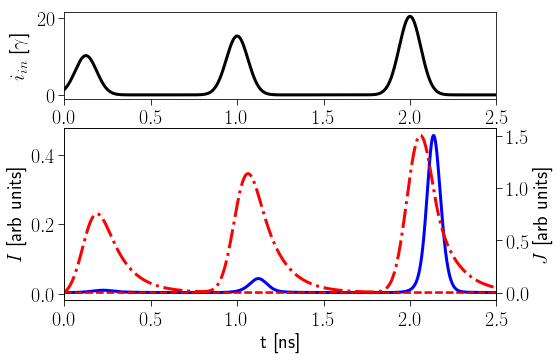

In [11]:
fig4=Y0Neuron1.visualize_plot(x01, y_out01, time01, y0_steady)
fig4.axes[0].set_xlabel('t [ns]');
fig4.savefig('./docs/graphics/simple_neuron_dyn.png', bbox_inches='tight')


As a final demo we show how the integrated laser neuron can be used for coincidence detection, only firing if it receives two input pulses in a narrow window.  We also show that inhibitory pulses can be sent to prevent spiking.

In [12]:
#Same integrated Neuron, showing Cooincidence detection

Y0Neuron2=Neuron(Y0params)
#create time signal, set params in terms of gamma1
t02_end=28./Y0mpars["gamma"]; #atleast this long
N02=int(np.ceil(t02_end/Y0Neuron2.dt)) #this many points
time02=np.linspace(0.,(N02-1)*Y0Neuron2.dt, num=N02 )


#choose gaussian input
x02=np.zeros(N02)
x02+=0.2*Gaussian_pulse(time02, 1/Y0mpars["gamma"], 1.e-1/Y0mpars["gamma"])
x02+=0.2*Gaussian_pulse(time02, 8./Y0mpars["gamma"], 1.e-1/Y0mpars["gamma"])
x02+=0.2*Gaussian_pulse(time02, 10./Y0mpars["gamma"], 1.e-1/Y0mpars["gamma"])
x02+=0.2*Gaussian_pulse(time02, 17./Y0mpars["gamma"], 1.e-1/Y0mpars["gamma"])
x02+=0.2*Gaussian_pulse(time02, 18./Y0mpars["gamma"], 1.e-1/Y0mpars["gamma"])
x02+=0.2*Gaussian_pulse(time02, 24./Y0mpars["gamma"], 1.e-1/Y0mpars["gamma"])
x02+=-0.2*Gaussian_pulse(time02, 24.5/Y0mpars["gamma"], 1.e-1/Y0mpars["gamma"])
x02+=0.2*Gaussian_pulse(time02, 25./Y0mpars["gamma"], 1.e-1/Y0mpars["gamma"])
x02=Y0mpars["gamma"]*(1-Y0mpars["P"])*x02 #put in units of difference to threshold
#solve
y_out02=Y0Neuron2.solve(x02)

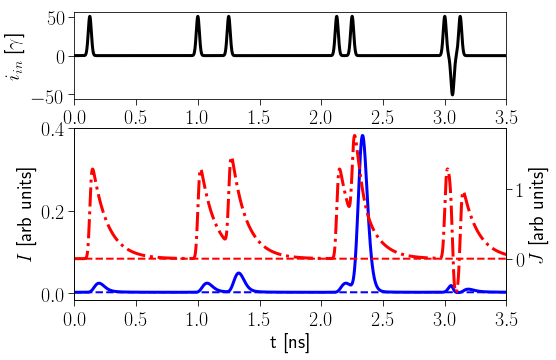

In [13]:
fig5=Y0Neuron2.visualize_plot(x02, y_out02, time02, y0_steady)
fig5.axes[0].set_xlabel('t [ns]');
# fig5.savefig('./docs/graphics/cooincidence_neuron_dyn.png', bbox_inches='tight')
